<a href="https://colab.research.google.com/github/giovanirojascuela/2025_5TO01/blob/RenaII/TALLER/EVALUACION/Renato_Fabrizio_Gonzales_Olazabal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resumen estadístico:
                                date                       datetime  \
count                           3898                           3898   
mean   2024-10-10 15:43:29.953822464  2024-10-11 06:25:20.199449600   
min              2024-03-01 00:00:00     2024-03-01 10:15:50.520000   
25%              2024-07-16 06:00:00  2024-07-16 23:53:19.049750016   
50%              2024-10-15 00:00:00     2024-10-15 21:26:44.176000   
75%              2025-02-03 00:00:00  2025-02-03 14:36:55.778250240   
max              2025-03-23 00:00:00            2025-03-23 21:23:11   
std                              NaN                            NaN   

            money  
count  3898.00000  
mean     31.38060  
min      15.00000  
25%      27.92000  
50%      32.82000  
75%      35.76000  
max      40.00000  
std       5.06461  


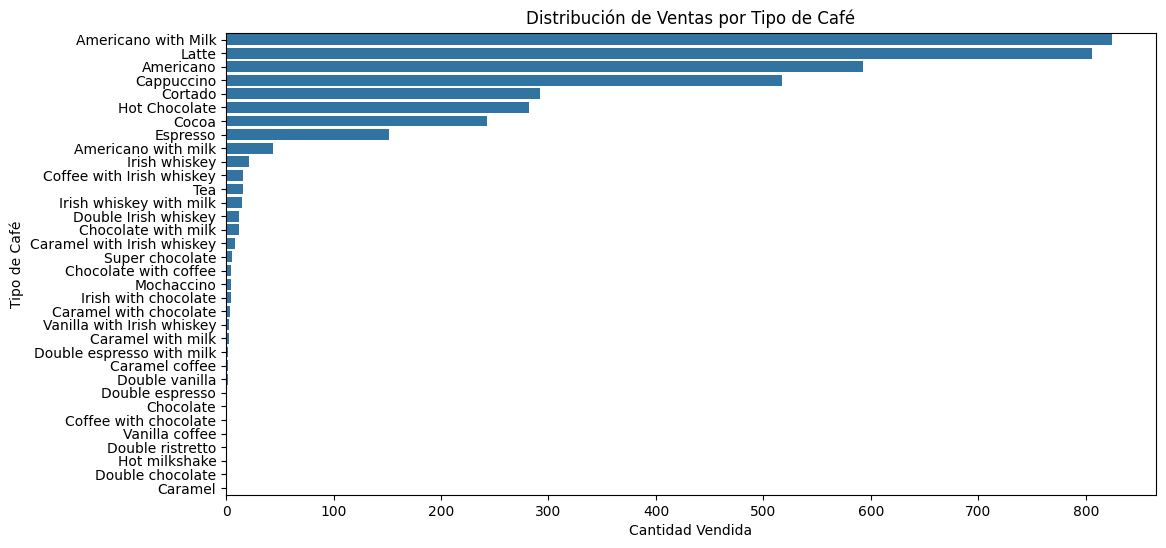

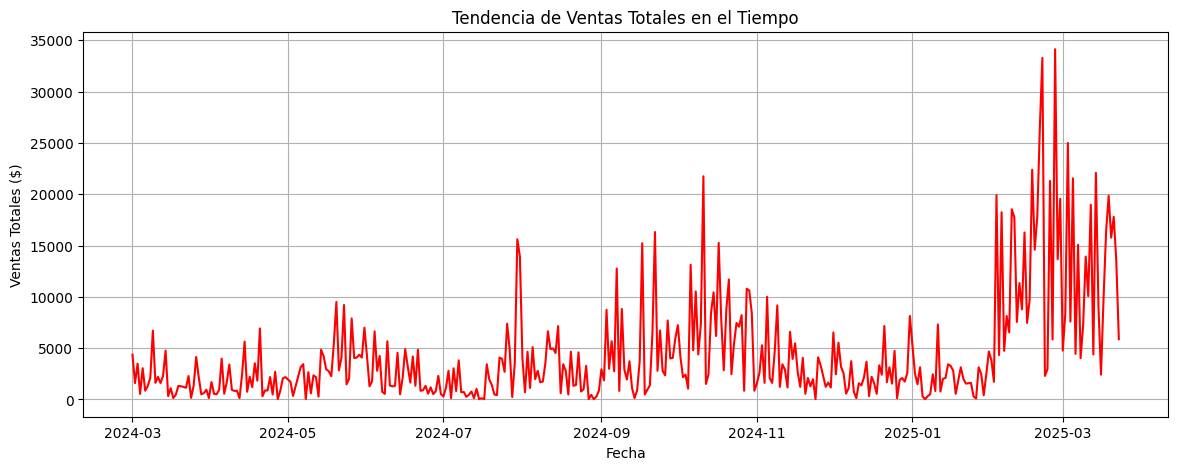

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import joblib

df1 = pd.read_csv('index_1.csv', parse_dates=['date', 'datetime'])
df2 = pd.read_csv('index_2.csv', parse_dates=['date', 'datetime'])

df = pd.concat([df1, df2], ignore_index=True)

print("Resumen estadístico:")
print(df.describe())

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='coffee_name', order=df['coffee_name'].value_counts().index)
plt.title('Distribución de Ventas por Tipo de Café')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Tipo de Café')
plt.show()

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['day_of_week'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour

daily_sales = df.groupby('date').agg({
    'money': 'sum',
    'coffee_name': 'count'
}).rename(columns={'money': 'total_sales', 'coffee_name': 'total_transactions'})

df = df.merge(daily_sales, left_on='date', right_index=True)

X_total = df[['month', 'day', 'day_of_week', 'hour']]
y_total = df['total_sales']

X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(
    X_total, y_total, test_size=0.2, random_state=42)

coffee_types = df['coffee_name'].unique()
coffee_encoder = OneHotEncoder()
coffee_encoded = coffee_encoder.fit_transform(df[['coffee_name']]).toarray()

daily_coffee_sales = df.groupby(['date', 'coffee_name']).size().unstack(fill_value=0)

daily_features = df.groupby('date').first()[['month', 'day', 'day_of_week']]
X_coffee = daily_features.merge(daily_coffee_sales, left_index=True, right_index=True)

X_train_coffee, X_test_coffee, y_train_coffee, y_test_coffee = train_test_split(
    X_coffee.iloc[:, :-len(coffee_types)],
    X_coffee.iloc[:, -len(coffee_types):],
    test_size=0.2,
    random_state=42)

preprocessor_total = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['month', 'day', 'day_of_week', 'hour'])
    ])

preprocessor_coffee = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['month', 'day', 'day_of_week'])
    ])

plt.figure(figsize=(14, 5))
df_daily = df.groupby('date')['total_sales'].sum().reset_index()
sns.lineplot(data=df_daily, x='date', y='total_sales', color='red')
plt.title('Tendencia de Ventas Totales en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ventas Totales ($)')
plt.grid(True)
plt.show()


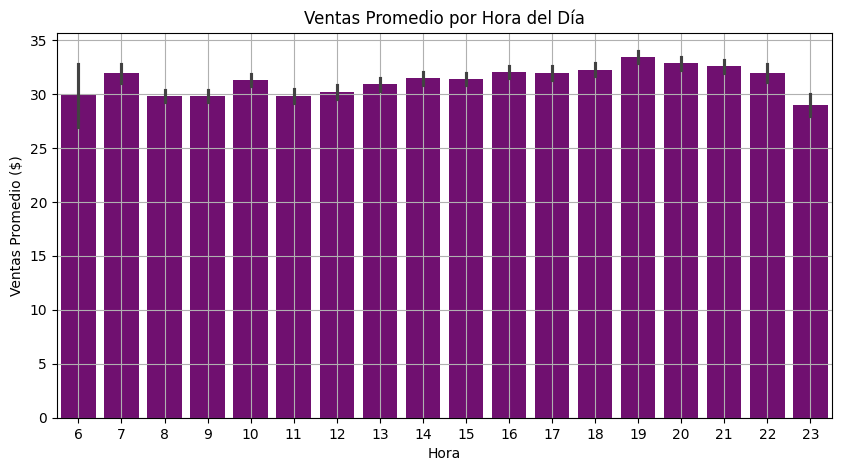

In [7]:
plt.figure(figsize=(10, 5))
sns.barplot(x='hour', y='money', data=df, estimator=np.mean, color='purple')
plt.title('Ventas Promedio por Hora del Día')
plt.xlabel('Hora')
plt.ylabel('Ventas Promedio ($)')
plt.grid(True)
plt.show()

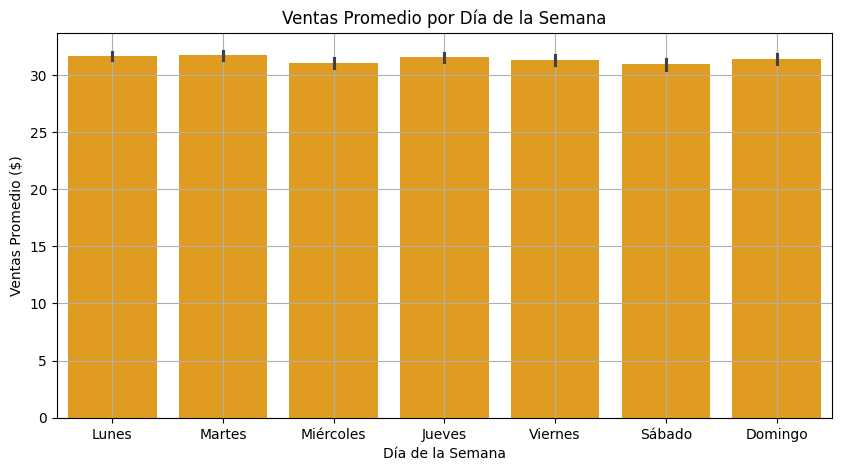

In [8]:
plt.figure(figsize=(10, 5))
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
sns.barplot(x='day_of_week', y='money', data=df, estimator=np.mean, color='orange')
plt.xticks(ticks=range(7), labels=dias)
plt.title('Ventas Promedio por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Ventas Promedio ($)')
plt.grid(True)

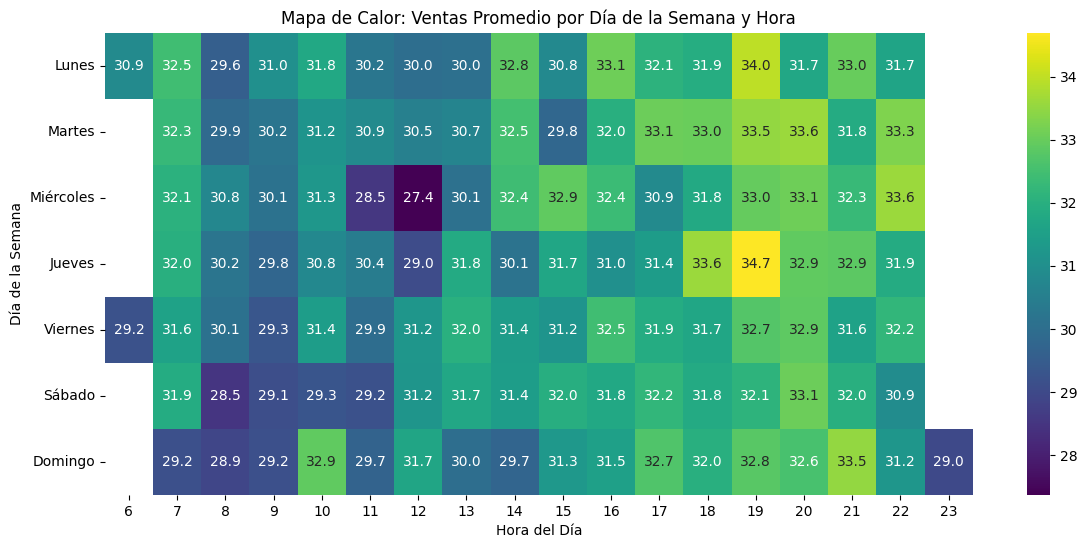

In [9]:
pivot = df.pivot_table(index='day_of_week', columns='hour', values='money', aggfunc='mean')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap='viridis', annot=True, fmt='.1f')
plt.title('Mapa de Calor: Ventas Promedio por Día de la Semana y Hora')
plt.xlabel('Hora del Día')
plt.ylabel('Día de la Semana')
plt.yticks(ticks=np.arange(7)+0.5, labels=dias, rotation=0)
plt.show()

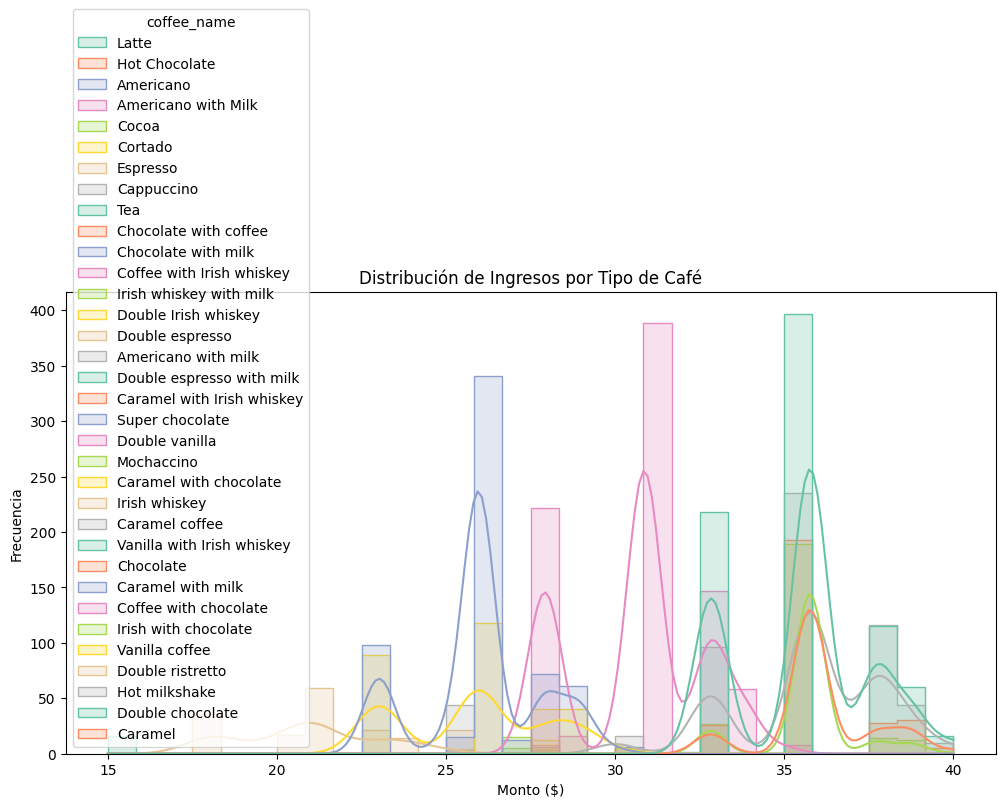

In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='money', hue='coffee_name', bins=30, kde=True, element='step', palette='Set2')
plt.title('Distribución de Ingresos por Tipo de Café')
plt.xlabel('Monto ($)')
plt.ylabel('Frecuencia')
plt.show()

/tmp/ipython-input-11-3335514644.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='coffee_name', y='money', data=df, palette='cubehelix') # Color cambiado a 'cubehelix'


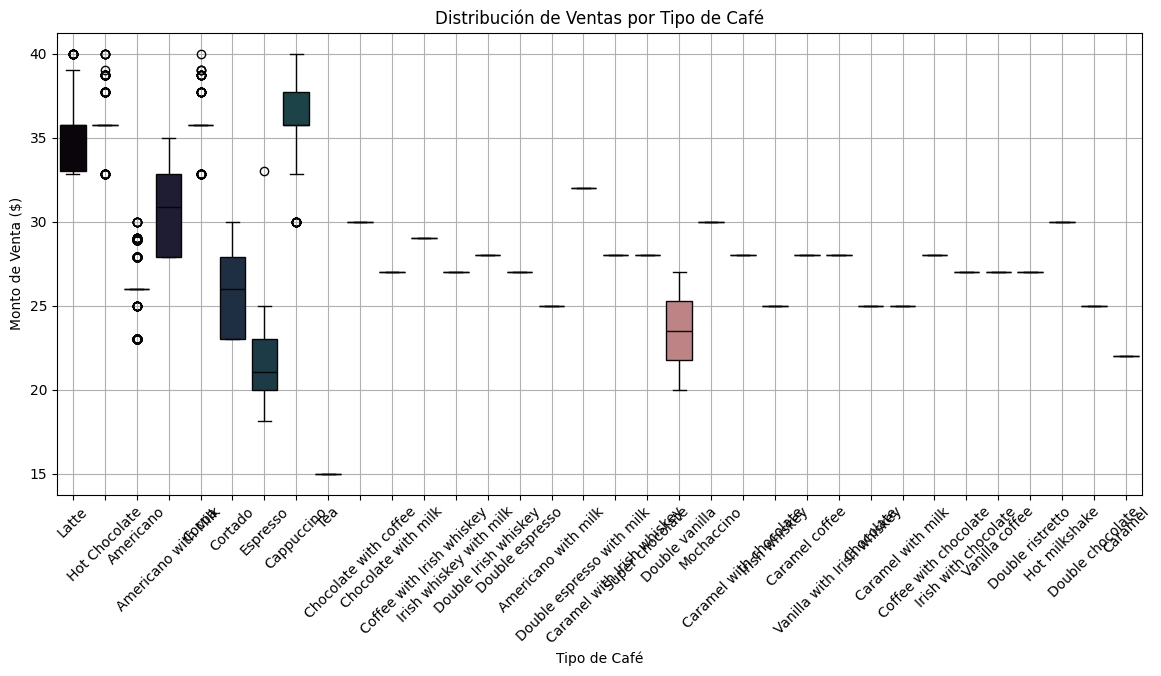

In [11]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='coffee_name', y='money', data=df, palette='cubehelix')
plt.title('Distribución de Ventas por Tipo de Café')
plt.xlabel('Tipo de Café')
plt.ylabel('Monto de Venta ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

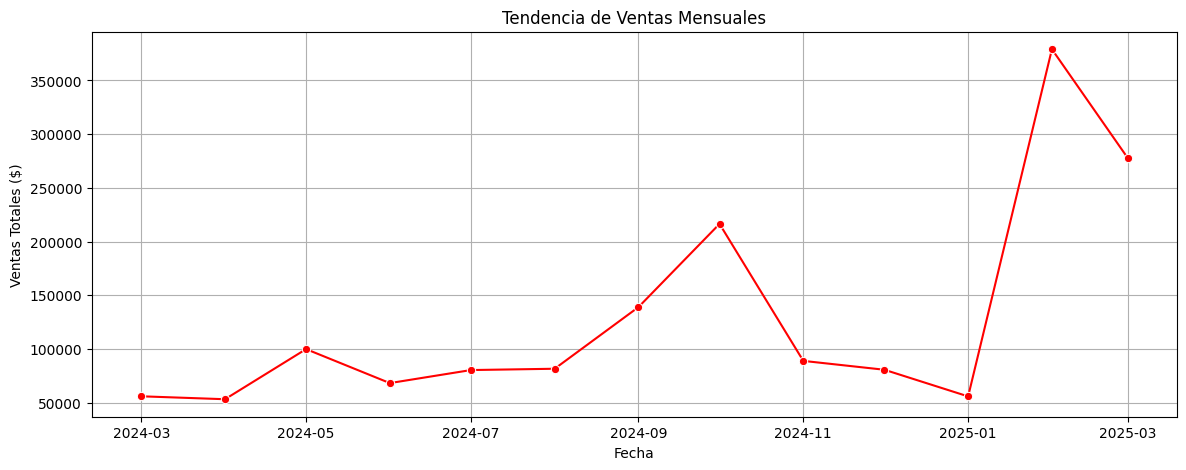

In [12]:
df_monthly = df.groupby(['year', 'month'])['total_sales'].sum().reset_index()
df_monthly['fecha'] = pd.to_datetime(df_monthly[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 5))
sns.lineplot(data=df_monthly, x='fecha', y='total_sales', marker='o', color='red')
plt.title('Tendencia de Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ventas Totales ($)')
plt.grid(True)
plt.show()

In [13]:
import warnings
warnings.filterwarnings('ignore')
model_total = Pipeline([
    ('preprocessor', preprocessor_total),
    ('regressor', keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(4,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ]))
])

model_total.named_steps['regressor'].compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mse']
)

history_total = model_total.named_steps['regressor'].fit(
    preprocessor_total.fit_transform(X_train_total),
    y_train_total,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_results_total = model_total.named_steps['regressor'].evaluate(
    preprocessor_total.transform(X_test_total),
    y_test_total,
    verbose=0
)

print(f"\nResultados del modelo de ventas totales:")
print(f"MAE: {test_results_total[1]:.2f}")
print(f"MSE: {test_results_total[2]:.2f}")
print(f"RMSE: {np.sqrt(test_results_total[2]):.2f}")


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 221248.5469 - mae: 422.3387 - mse: 221248.5469 - val_loss: 224572.5625 - val_mae: 424.9183 - val_mse: 224572.5625
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 219895.3281 - mae: 420.2243 - mse: 219895.3281 - val_loss: 188207.6250 - val_mae: 380.3436 - val_mse: 188207.6250
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 167896.4844 - mae: 354.8497 - mse: 167896.4844 - val_loss: 109677.9453 - val_mae: 266.1406 - val_mse: 109677.9453
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87031.4609 - mae: 230.6926 - mse: 87031.4609 - val_loss: 51129.3438 - val_mae: 177.8982 - val_mse: 51129.3438
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43825.7266 - mae: 163.2054 - mse: 43825.7266 - val_loss: 42099.2148 - val_mae: 169.3307 - val_mse: 42099.2148
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39827.6250 - mae: 160.1462 - mse: 39827.6250 - val_loss: 41658.4258 - val_mae: 169.1042 - 

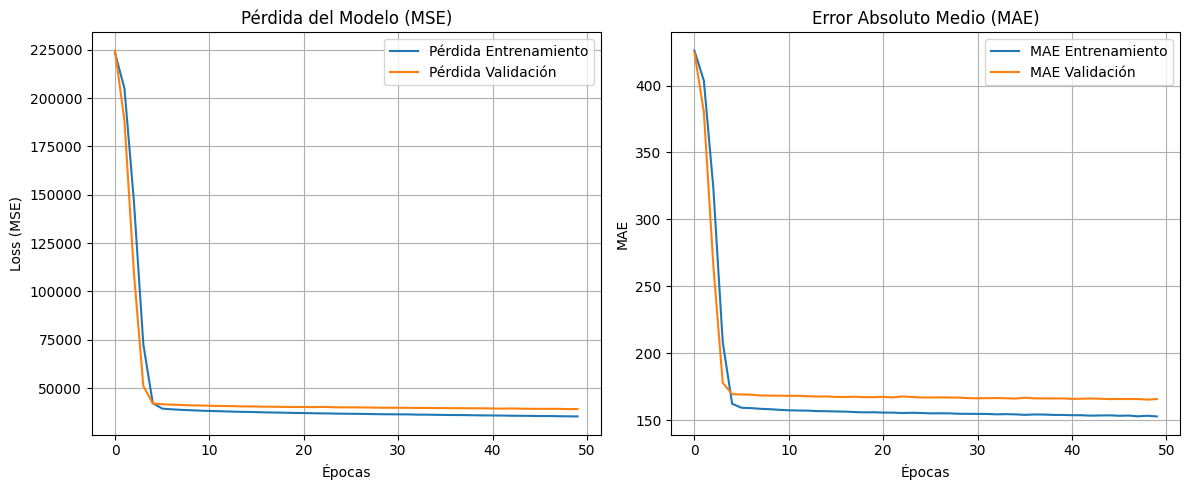

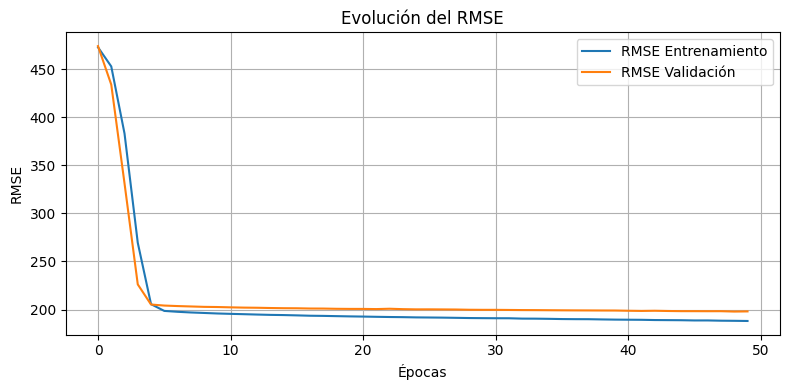

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


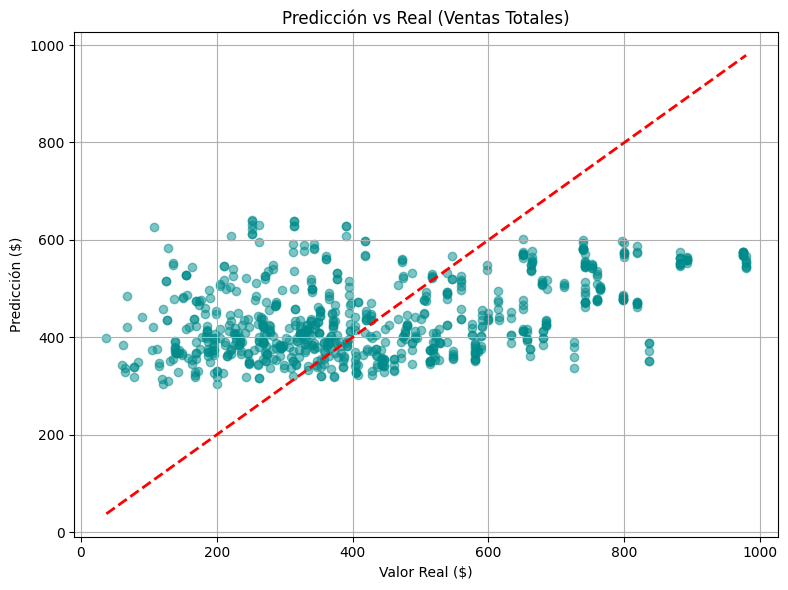

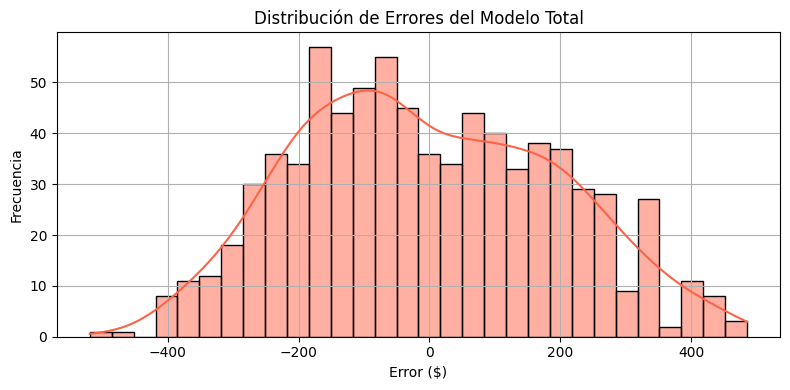

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_total.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history_total.history['val_loss'], label='Pérdida Validación')
plt.title('Pérdida del Modelo (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_total.history['mae'], label='MAE Entrenamiento')
plt.plot(history_total.history['val_mae'], label='MAE Validación')
plt.title('Error Absoluto Medio (MAE)')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

rmse_train = np.sqrt(history_total.history['loss'])
rmse_val = np.sqrt(history_total.history['val_loss'])

plt.figure(figsize=(8, 4))
plt.plot(rmse_train, label='RMSE Entrenamiento')
plt.plot(rmse_val, label='RMSE Validación')
plt.title('Evolución del RMSE')
plt.xlabel('Épocas')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

X_test_total_preprocessed = preprocessor_total.transform(X_test_total)
y_pred_total = model_total.named_steps['regressor'].predict(X_test_total_preprocessed).flatten()

plt.figure(figsize=(8, 6))
plt.scatter(y_test_total, y_pred_total, alpha=0.5, color='darkcyan')
plt.plot([y_test_total.min(), y_test_total.max()],
         [y_test_total.min(), y_test_total.max()],
         'r--', lw=2)
plt.title('Predicción vs Real (Ventas Totales)')
plt.xlabel('Valor Real ($)')
plt.ylabel('Predicción ($)')
plt.grid(True)

plt.tight_layout()
plt.show()

errors_total = y_test_total.values - y_pred_total

plt.figure(figsize=(8, 4))
sns.histplot(errors_total, bins=30, kde=True, color='tomato')
plt.title('Distribución de Errores del Modelo Total')
plt.xlabel('Error ($)')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
import numpy as np

model_coffee = Pipeline([
    ('preprocessor', preprocessor_coffee),
    ('regressor', keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(3,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(coffee_types))
    ]))
])

model_coffee.named_steps['regressor'].compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mse']
)

history_coffee = model_coffee.named_steps['regressor'].fit(
    preprocessor_coffee.fit_transform(X_train_coffee),
    y_train_coffee,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_results_coffee = model_coffee.named_steps['regressor'].evaluate(
    preprocessor_coffee.transform(X_test_coffee),
    y_test_coffee,
    verbose=0
)

print(f"\nResultados del modelo por tipo de café:")
print(f"MAE: {test_results_coffee[1]:.2f}")
print(f"MSE: {test_results_coffee[2]:.2f}")
print(f"RMSE: {np.sqrt(test_results_coffee[2]):.2f}")


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.9915 - mae: 0.4180 - mse: 0.9915 - val_loss: 0.9364 - val_mae: 0.3854 - val_mse: 0.9364
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8835 - mae: 0.3705 - mse: 0.8835 - val_loss: 0.8669 - val_mae: 0.3619 - val_mse: 0.8669
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8622 - mae: 0.3629 - mse: 0.8622 - val_loss: 0.7987 - val_mae: 0.3526 - val_mse: 0.7987
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8281 - mae: 0.3549 - mse: 0.8281 - val_loss: 0.7275 - val_mae: 0.3463 - val_mse: 0.7275
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7052 - mae: 0.3406 - mse: 0.7052 - val_loss: 0.6588 - val_mae: 0.3379 - val_mse: 0.6588
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5787 - mae: 0.3196 - mse: 0.5787 - val_loss: 0.6027 - val_mae: 0.3292 - val_mse: 0.6027
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5835 - mae: 0.3203 - mse: 0.5835 - val_loss: 0.5639 - val_m

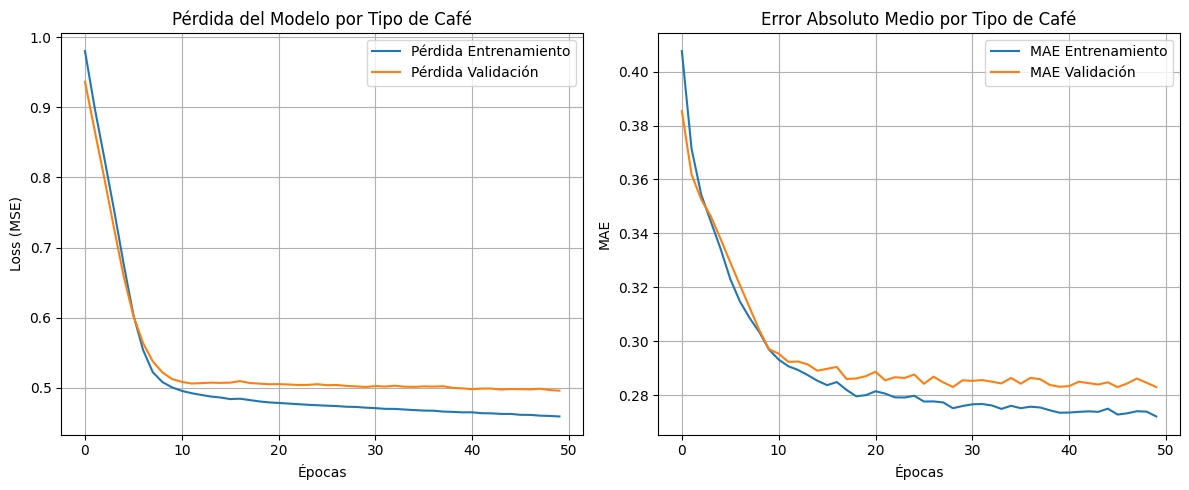

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_coffee.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history_coffee.history['val_loss'], label='Pérdida Validación')
plt.title('Pérdida del Modelo por Tipo de Café')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_coffee.history['mae'], label='MAE Entrenamiento')
plt.plot(history_coffee.history['val_mae'], label='MAE Validación')
plt.title('Error Absoluto Medio por Tipo de Café')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
# Guardar los modelos y preprocesadores en formato .keras (nativo de Keras)
model_total.named_steps['regressor'].save('models/sales_total_model.keras')
model_coffee.named_steps['regressor'].save('models/sales_coffee_model.keras')

# Guardar preprocesadores
with open('models/preprocessor_total.pkl', 'wb') as f:
    pickle.dump(preprocessor_total, f)

with open('models/preprocessor_coffee.pkl', 'wb') as f:
    pickle.dump(preprocessor_coffee, f)

with open('models/coffee_encoder.pkl', 'wb') as f:
    pickle.dump(coffee_encoder, f)

# Guardar la lista de tipos de café
print("Modelos guardados correctamente.")

import os
print(os.listdir('models'))


FileNotFoundError: [Errno 2] No such file or directory: 'models/sales_total_model.keras'